# Lending Club - Analysis and Modelling

The objective of this project is to prepare a model that can accurately predict if a loan will default or not.

The dataset is from the Lending Club, a peer-to-peer lending company based in the United States. Investors can fund potential borrowers and and earn a profit depending on the risk they take. The risk is assessed with the borrower's credit score. 

## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline

In [2]:
og_df = pd.read_csv('loan.csv', low_memory=False)

It is better practice to work on a copy of the dataset, so the dataset does not have to be re-read again, thus saving memory.

In [3]:
df = og_df.copy(deep=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Print the shape of the dataset**

In [4]:
df.shape

(887379, 74)

**Print the column names**

In [5]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

## Understand the data

In [6]:
df_description = pd.read_excel('LCDataDictionary.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


**Find columns with missing values**

In [7]:
def find_missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print ("Dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
   
    return mis_val_table_ren_columns

In [8]:
missing_values = find_missing_values(df)
missing_values.head(20)

Dataframe has 74 columns.
There are 40 columns that have missing values.


,Missing Values,% of Total Values
dti_joint,886870,99.9
annual_inc_joint,886868,99.9
verification_status_joint,886868,99.9
il_util,868762,97.9
mths_since_rcnt_il,866569,97.7
total_cu_tl,866007,97.6
inq_fi,866007,97.6
all_util,866007,97.6
max_bal_bc,866007,97.6
open_rv_24m,866007,97.6


**There are a lot of columns with too much missing data. Columns will have to be removed later.**

Let's determine how many loans went to default

In [9]:
target_list = [1 if i=='Default' else 0  for i in df['loan_status']]

df['TARGET'] = target_list
df['TARGET'].value_counts()

0    886160
1      1219
Name: TARGET, dtype: int64

**It is clear that the dataset is imbalenced, since the amount of defaulted loans is significantly small. Appropriate cost function and sampling techniques will have to be used to prevent bias when modelling.**

In [10]:
df.drop('loan_status', axis=1, inplace=True)

Text(0,0.5,'Data type')

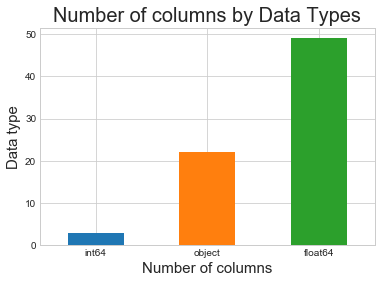

In [11]:
df.dtypes.value_counts().sort_values().plot(kind='bar')
plt.title('Number of columns by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.xticks(rotation=0)
plt.ylabel('Data type',fontsize=15)

**The 'object' columns will need more processing before being usable for modelling**

### Anomaly Detection

Anomalies often arise in columns dealing with time. Let's see if anomalies arise in this dataset.

In [12]:
df['emp_length'].head(3)

0    10+ years
1     < 1 year
2    10+ years
Name: emp_length, dtype: object

**Fill missing values with 0, assuming the borrower has not worked for many years for the data to be recorded.** 

Text(0.5,0,'Years worked')

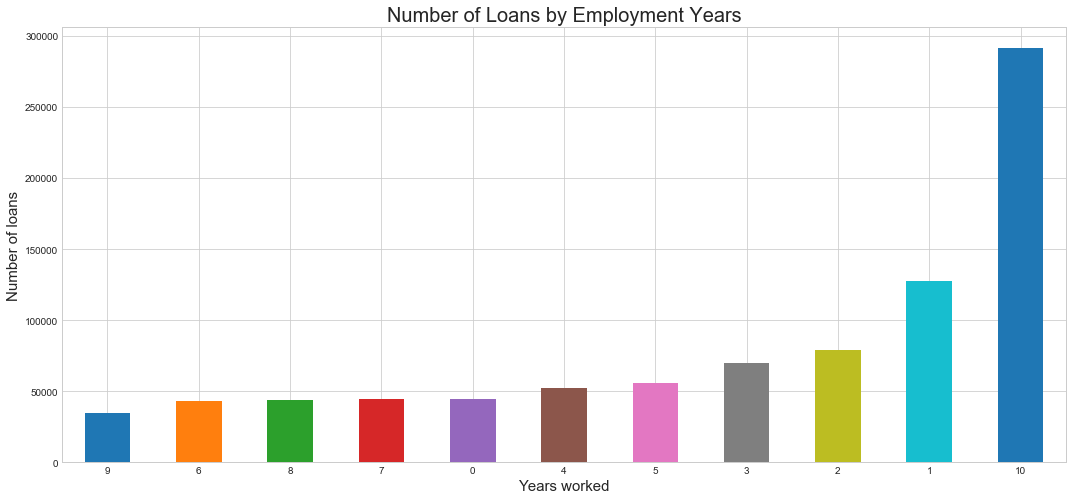

In [13]:
df['emp_length'].fillna(value=0, inplace=True)

df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

df['emp_length'].value_counts().sort_values().plot(kind='bar', figsize=(18,8))
plt.title('Number of Loans by Employment Years', fontsize=20)
plt.ylabel('Number of loans', fontsize=15)
plt.xticks(rotation=0)
plt.xlabel('Years worked', fontsize=15)

**No anomalies is detected. People who have worked more than 10 years are more likely to take a loan.**

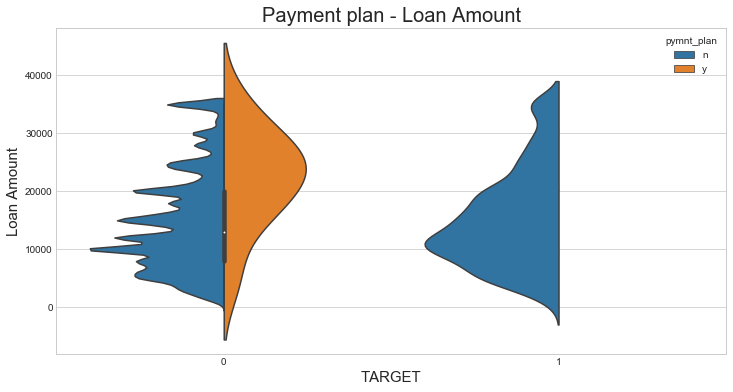

In [14]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="TARGET",y="loan_amnt",data=df, hue="pymnt_plan", split=True)
plt.title("Payment plan - Loan Amount", fontsize=20)
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

**Defaulted loans do not have a payment plan**

### Exploratory Data Analysis

Remove columns with more than 70% missing data. 

In [15]:
col_to_drop = [i for i in df.count() < 887379 * 0.3]
df.drop(df.columns[col_to_drop], axis=1, inplace=True)

Display the most correlated features to the target

In [16]:
correlations = df.corr()['TARGET'].sort_values()

print('Most positive correlations:\n', correlations.tail(10))
print('Most negative correlations:\n', correlations.head(10))

Most positive correlations:
 dti                   0.003912
revol_util            0.004831
inq_last_6mths        0.006042
total_rec_int         0.010490
total_rec_late_fee    0.011758
out_prncp             0.013938
out_prncp_inv         0.013944
int_rate              0.024485
TARGET                1.000000
policy_code                NaN
Name: TARGET, dtype: float64
Most negative correlations:
 last_pymnt_amnt    -0.013132
total_rec_prncp    -0.012085
id                 -0.010041
member_id          -0.009836
total_pymnt        -0.007590
total_pymnt_inv    -0.007448
tot_cur_bal        -0.007036
annual_inc         -0.004743
total_rev_hi_lim   -0.004729
recoveries         -0.004157
Name: TARGET, dtype: float64


**The interest rate and the outstanding principle have the highest positive correlation with the loan status. This makes sense, since a higher interest rate makes the loan harder to pay. Likewise, a greater outstanding principle can hint for difficulties in repaying the loan. On the other hand, the recoveries are negatively correlated, because the smaller they are, the more likely the loan is to be paid. Likewise, the larger the last payment amout, the more likely the loan will be reimbursed.**

#### Correlation to interest rate

In [17]:
df.corr()['int_rate'].sort_values()

total_rev_hi_lim             -0.166119
id                           -0.142963
member_id                    -0.142205
tot_cur_bal                  -0.091408
annual_inc                   -0.072786
total_acc                    -0.038618
revol_bal                    -0.035708
mths_since_last_delinq       -0.030033
open_acc                     -0.010381
tot_coll_amt                  0.001130
collections_12_mths_ex_med    0.013336
TARGET                        0.024485
acc_now_delinq                0.026478
out_prncp_inv                 0.042529
out_prncp                     0.042671
pub_rec                       0.052156
total_rec_prncp               0.054975
delinq_2yrs                   0.055178
total_rec_late_fee            0.057150
collection_recovery_fee       0.070867
dti                           0.079903
last_pymnt_amnt               0.101179
recoveries                    0.106840
installment                   0.133075
loan_amnt                     0.145023
funded_amnt              



With no surprise, the total interest received highly correlates with the interest rate. No interesting insight is offered here.


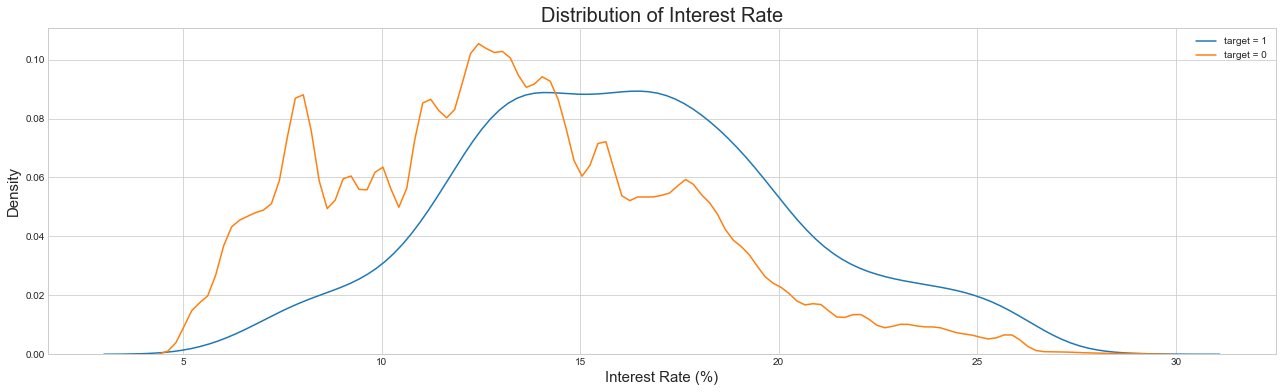

In [18]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df.loc[df['TARGET'] == 1, 'int_rate'], label = 'target = 1')
sns.kdeplot(df.loc[df['TARGET'] == 0, 'int_rate'], label = 'target = 0');
plt.xlabel('Interest Rate (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Interest Rate',fontsize=20);

**The interest rate seems to be quite normaly distributed for both defaulted and good loans**


#### Explore term and loan amount

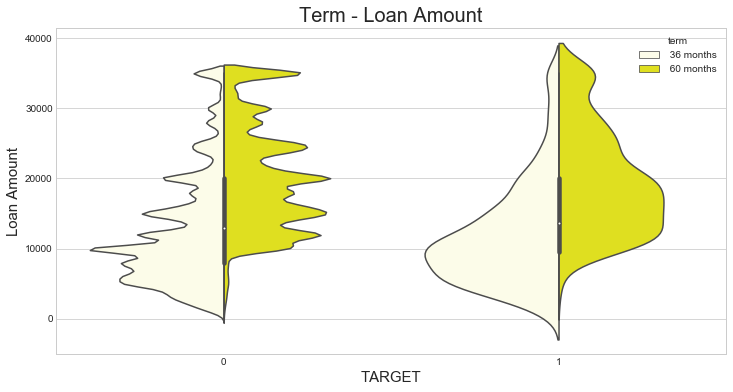

In [19]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="TARGET",y="loan_amnt",data=df, hue="term", split=True,color='yellow')
plt.title("Term - Loan Amount", fontsize=20)
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

**The greater the loan amout, the more likely the term is to be of 60 months**


#### Explore application type and loan amount

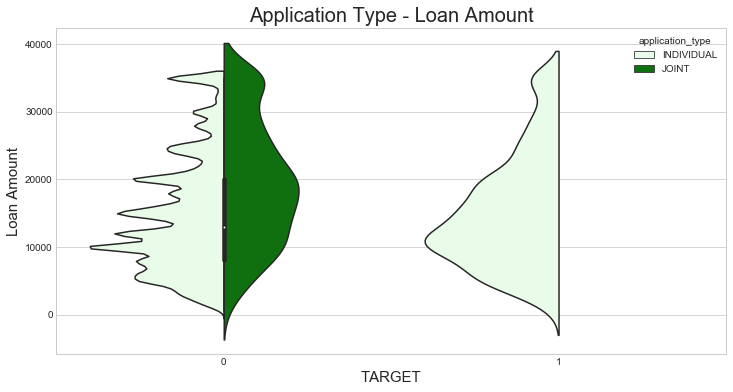

In [20]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="TARGET",y="loan_amnt",data=df, hue="application_type", split=True,color='green')
plt.title("Application Type - Loan Amount", fontsize=20)
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

In [21]:
df['application_type'].value_counts()

INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64

**Interestingly, defaulted loans are from individual people only.Unfortunately, the number of joint applications is not significant enough to conclude that all joint applications are reimbursed**


#### Credit grade and interest rate

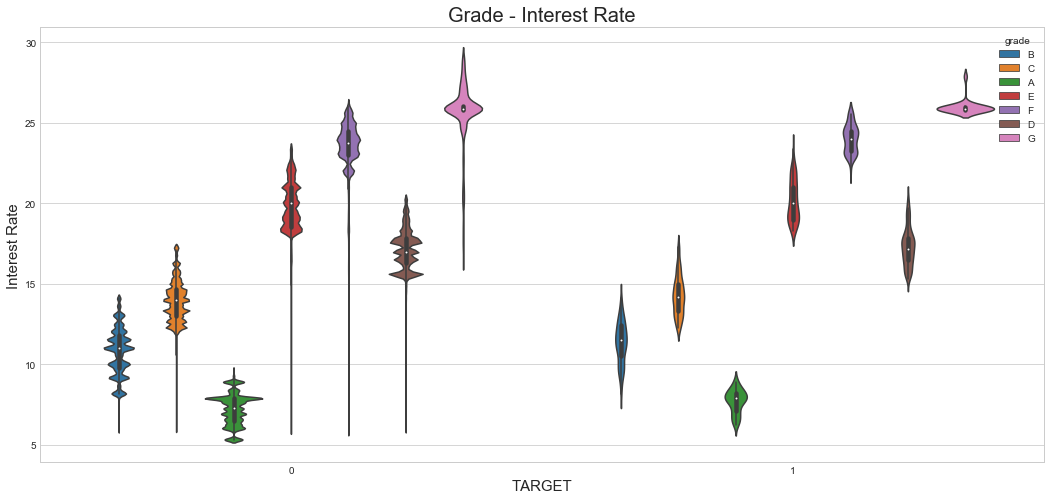

In [22]:
fig = plt.figure(figsize=(18,8))
sns.violinplot(x="TARGET",y="int_rate",data=df, hue="grade")
plt.title("Grade - Interest Rate", fontsize=20)
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Interest Rate", fontsize=15);

**For both paid and defaulted loans, there is a similar distribution of credit score.**


#### Loan status and location

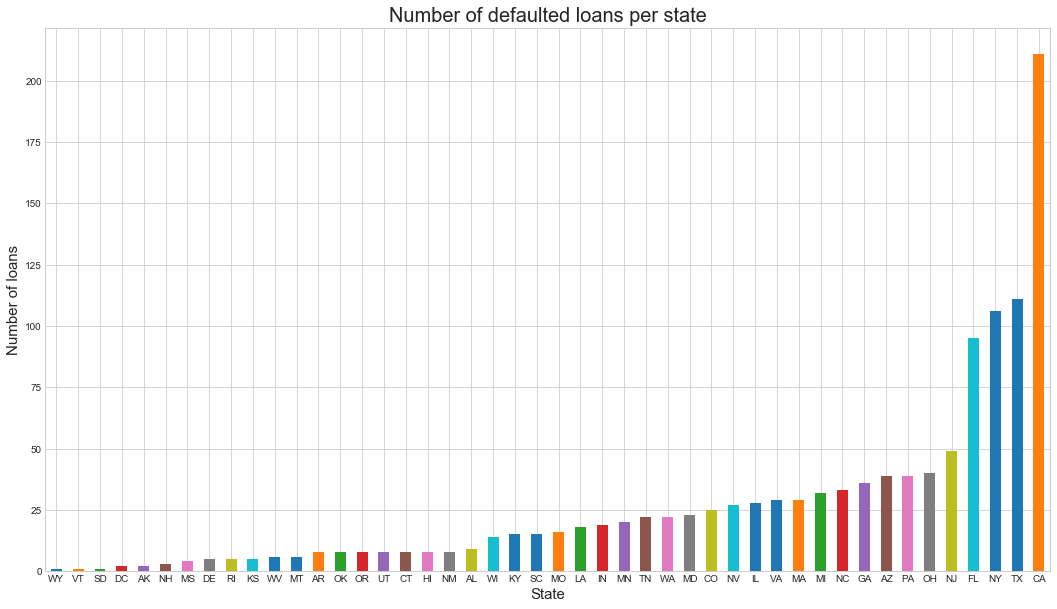

In [23]:
fig = plt.figure(figsize=(18,10))
df[df['TARGET']==1].groupby('addr_state')['TARGET'].count().sort_values().plot(kind='bar')
plt.xlabel('State',fontsize=15)
plt.ylabel('Number of loans',fontsize=15)
plt.xticks(rotation=0)
plt.title('Number of defaulted loans per state',fontsize=20);

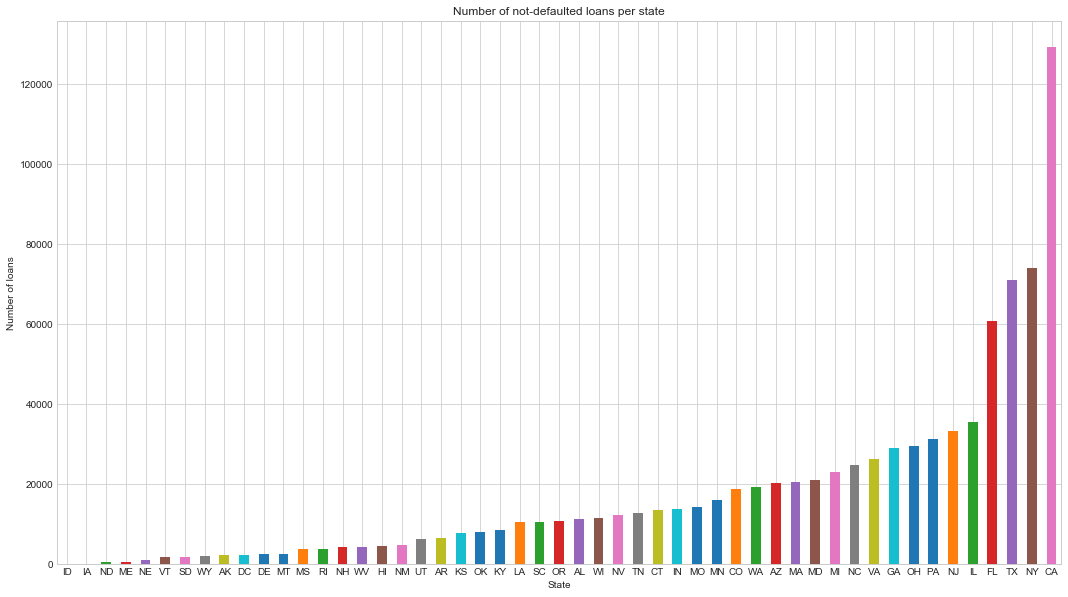

In [24]:
fig = plt.figure(figsize=(18,10))
df[df['TARGET']==0].groupby('addr_state')['TARGET'].count().sort_values().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Number of loans')
plt.xticks(rotation=0)
plt.title('Number of not-defaulted loans per state');

**From both graphs, the location is not a good indicator for the status of the loan, since states with a high number of loans will have also a higher number of defaulted loans
**

#### Do members take multiple loans?

In [25]:
df['member_id'].value_counts().head(2)

58732538    1
353782      1
Name: member_id, dtype: int64

It seems that no one has taken 2 loans on the Lending Club. Maybe it's a rule, but I didn't find any info on the website.

## Data cleaning

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 54 columns):
id                            887379 non-null int64
member_id                     887379 non-null int64
loan_amnt                     887379 non-null float64
funded_amnt                   887379 non-null float64
funded_amnt_inv               887379 non-null float64
term                          887379 non-null object
int_rate                      887379 non-null float64
installment                   887379 non-null float64
grade                         887379 non-null object
sub_grade                     887379 non-null object
emp_title                     835917 non-null object
emp_length                    887379 non-null object
home_ownership                887379 non-null object
annual_inc                    887375 non-null float64
verification_status           887379 non-null object
issue_d                       887379 non-null object
pymnt_plan                    887379 

In [27]:
df.drop(['id','member_id','emp_title','title','zip_code','url'],axis=1,inplace=True)

In [28]:
df.shape

(887379, 48)

We need to turn the object type to float or int in order to be used for modelling. Turn date object columns to integer, and fill the missing data with the mode

In [29]:
df['issue_d']= pd.to_datetime(df['issue_d']).apply(lambda x: int(x.strftime('%Y')))
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'].fillna('2016-01-01')).apply(lambda x: int(x.strftime('%m')))
df['last_credit_pull_d']= pd.to_datetime(df['last_credit_pull_d'].fillna("2016-01-01")).apply(lambda x: int(x.strftime('%m')))
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'].fillna('2001-08-01')).apply(lambda x: int(x.strftime('%m')))
df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'].fillna(value = '2016-02-01')).apply(lambda x:int(x.strftime("%Y")))

Label encoding and one-hot encoding

In [30]:
from sklearn import preprocessing

In [31]:
count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

term
pymnt_plan
initial_list_status
application_type
4 columns were label encoded.


In [32]:
df = pd.get_dummies(df)
print(df.shape)

(887379, 168)


Fill missing values with median as data is continuous

In [33]:
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(df['mths_since_last_delinq'].median())

In [34]:
df.dropna(inplace=True)

df['TARGET'].value_counts()

0    815522
1      1200
Name: TARGET, dtype: int64

## Modelling

### Logistic Regression - Baseline

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [36]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test)))) 

Train/test split

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('TARGET',axis=1),df['TARGET'],test_size=0.15,random_state=101)

Free memory

In [39]:
del og_df
gc.collect()

111

Standardize features

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

Oversampling only the training set using Synthetic Minority Oversampling Technique

In [42]:
from imblearn.over_sampling import SMOTE

In [43]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_r, y_train_r = sm.fit_sample(X_train, y_train)

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Logistic regression

In [44]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001,random_state=21)

log_reg.fit(x_train_r, y_train_r)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=21,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [45]:
print_score(log_reg, x_train_r, y_train_r, X_test, y_test, train=False)

Test Result:

accuracy score: 0.7933

Classification Report: 
              precision    recall  f1-score   support

          0       1.00      0.79      0.88    122332
          1       0.01      0.86      0.01       177

avg / total       1.00      0.79      0.88    122509


Confusion Matrix: 
 [[97036 25296]
 [   25   152]]



Precision is so bad!!!!!

### Random Forest - Avoid overfitting

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
clf_rf = RandomForestClassifier(n_estimators=40, random_state=21)

clf_rf.fit(x_train_r, y_train_r)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [48]:
print_score(clf_rf, x_train_r, y_train_r, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9986

Classification Report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    122332
          1       1.00      0.06      0.11       177

avg / total       1.00      1.00      1.00    122509


Confusion Matrix: 
 [[122332      0]
 [   167     10]]



Very low recall

### Boosting - Random Forest

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier

In [50]:
def kfold_lightgbm(train_df, num_folds, stratified = False):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

    oof_preds = np.zeros(train_df.shape[0])

    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET']]
    
    # Splitting the training set into folds for Cross Validation
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            )

        # Fitting the model and evaluating by AUC
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        print_score(clf, train_x, train_y, valid_x, valid_y, train=False)
        # Dataframe holding the different features and their importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # Freeing up memory
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    display_importances(feature_importance_df)
    return feature_importance_df

In [51]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (816722, 168)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.00182964	training's auc: 0.995352	valid_1's binary_logloss: 0.00185305	valid_1's auc: 0.994797
Test Result:



C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy score: 0.9997



C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification Report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    271831
          1       0.98      0.82      0.90       410

avg / total       1.00      1.00      1.00    272241




C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion Matrix: 
 [[271825      6]
 [    73    337]]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.00159339	training's auc: 0.996372	valid_1's binary_logloss: 0.00169487	valid_1's auc: 0.993876
Test Result:



C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy score: 0.9997



C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification Report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    271853
          1       0.97      0.81      0.88       388

avg / total       1.00      1.00      1.00    272241




C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion Matrix: 
 [[271844      9]
 [    74    314]]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.00215092	training's auc: 0.994937	valid_1's binary_logloss: 0.00214	valid_1's auc: 0.996462
Test Result:



C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy score: 0.9997



C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification Report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    271838
          1       0.98      0.81      0.89       402

avg / total       1.00      1.00      1.00    272240




C:\Users\marco\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion Matrix: 
 [[271831      7]
 [    75    327]]



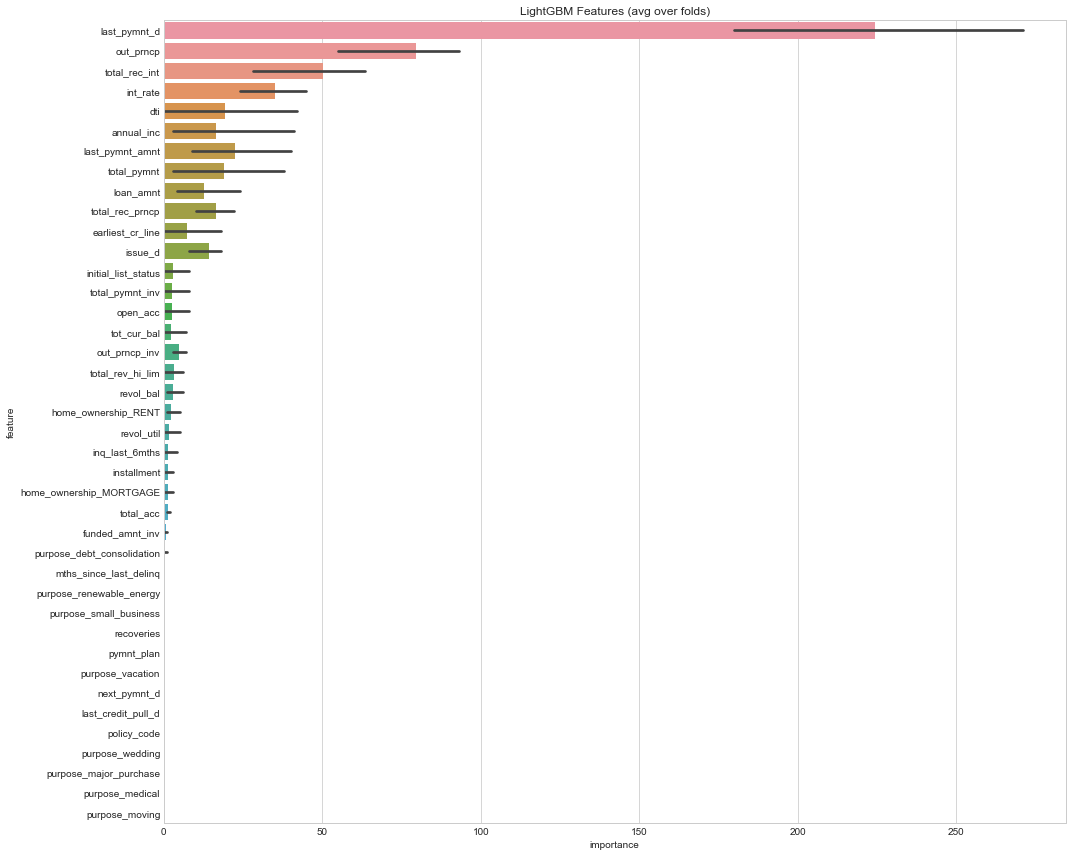

In [52]:
feat_importance = kfold_lightgbm(df, num_folds= 3, stratified= False)

Good! High precision and high recall!